# Transmisor 
- Codigo Fuente de Transmisor.ipynb
- Autor:  Uberti, Ulises Leandro
- Asignatura: Señales Electricas
- Año: 2025

# Archivo de Audio .wav
- Trabajamos con archivos de audio .wav
- Un archivo .wav guarda un formato RIFF el cual tiene una estructura separa por "chunks"
- Una parte de la estrucutra indica las caracteristicas del archivo
- Otra parte indica los datos correspondientes al audio

In [1]:
#Importamos las librerias necesarias 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#Subimos de nivel la carpeta para importar las funciones de otros archivos 
import sys 
sys.path.append("..")

#Importamos las funciones de otros archivos 
from modules.caracteristicas import Audio_Caracteristicas,Audio_FFT,Audio_Grafica
from scipy.signal import resample_poly
from scipy.io import wavfile
from modules.codificar import Codificar_Senial


In [2]:
# Obtenemos las caracterisitcas de la señal de audio 
ruta = "../datos/audio_prueba.wav" #variable con la direccion del archivo de audio (carpeta datos)
Canales,Bits_por_Muestra,fs,Cantidad_Muestras,duracion = Audio_Caracteristicas(ruta) #funcion para obtener las caracterisiticas dela archivo
print(Cantidad_Muestras)

Canales: 1
Bits por muestra: 16
Frecuencia de muestreo: 24000 Hz
Duración: 4.66 segundos
111744


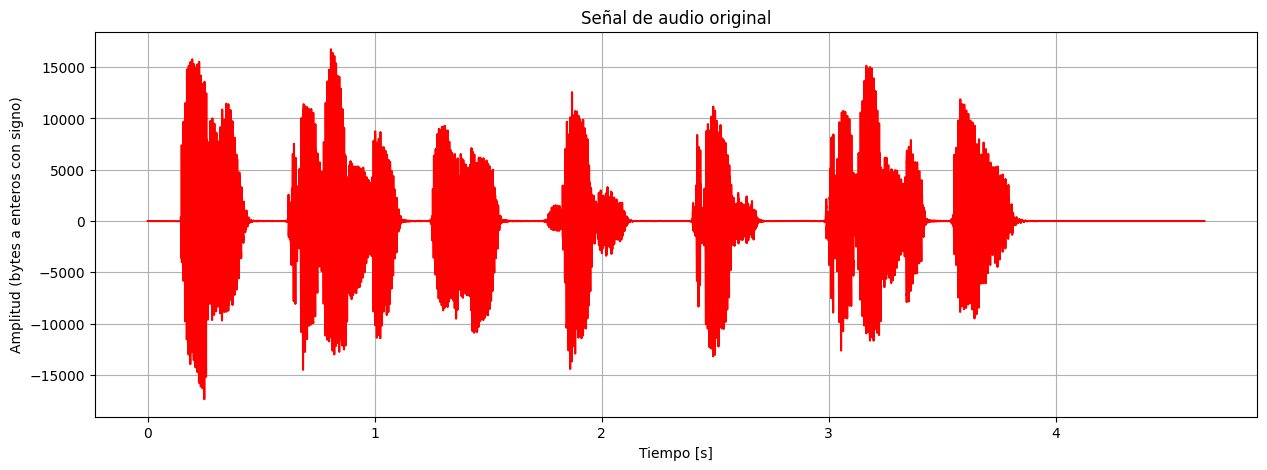

In [3]:
# Graficamos la señal de audio en funcion del tiempo
Audio_fs_16bits,t_audio_fs_16bits =Audio_Grafica(ruta)


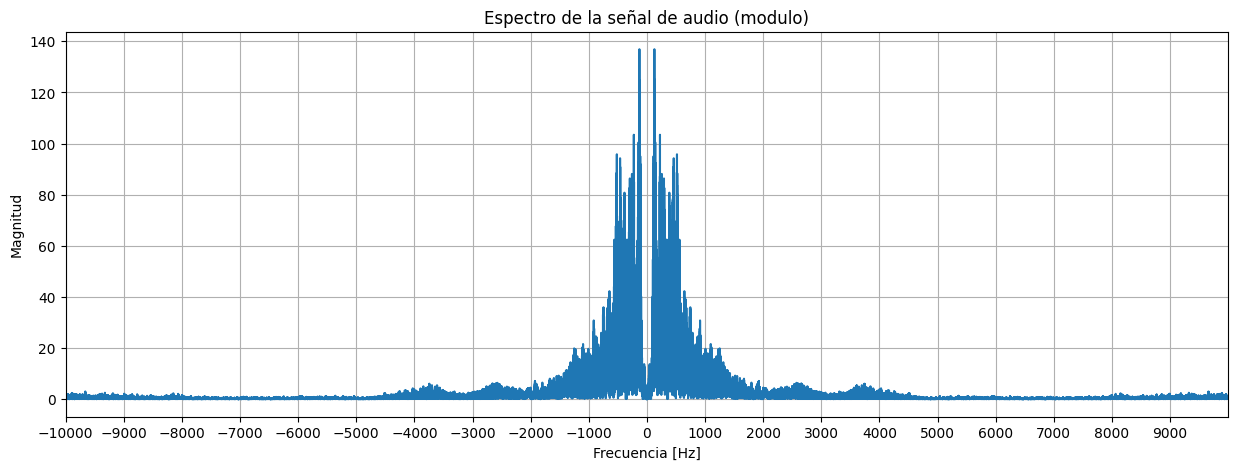

In [4]:
# Graficamos la FFT de la señal de audio 
fft_audio_fs_16bits,f_audio_fs_16bits = Audio_FFT(ruta)

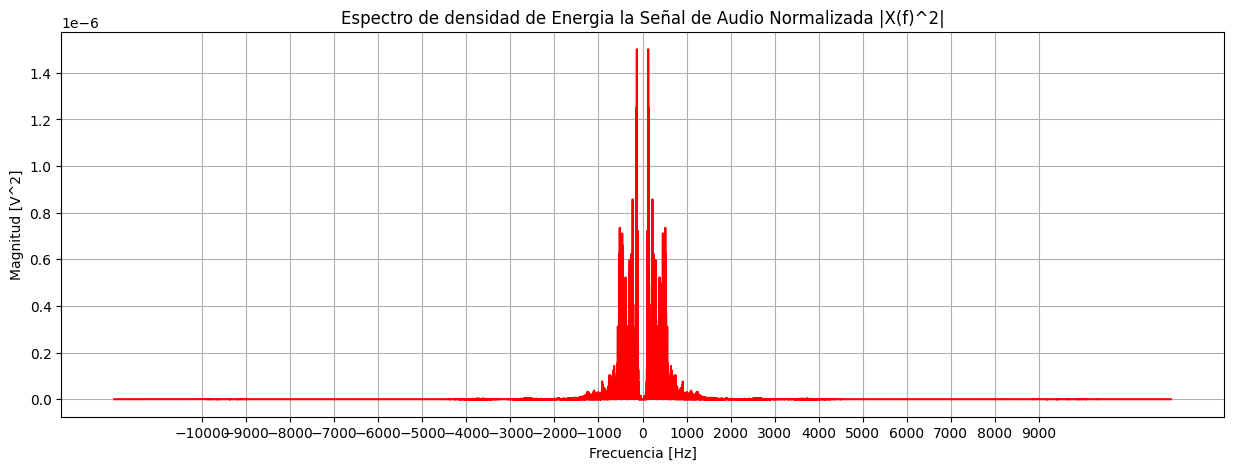

In [5]:
# Determinamos cual es la componente maxima a tener en cuenta en el espectro para remuestrear la señal
# Con el criterio del 95% de la energia 
# Calculamos el espectro de densidad de energia 
Energia_Espectro_Audio = (np.abs(fft_audio_fs_16bits/len(fft_audio_fs_16bits)))**2

#Graficamos 
plt.figure(figsize=(15,5))
plt.plot(f_audio_fs_16bits,Energia_Espectro_Audio,'red')
plt.title("Espectro de densidad de Energia la Señal de Audio Normalizada |X(f)^2|")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [V^2]")
plt.grid(True)
plt.xticks(np.arange(-10e3,10e3,1e3))
plt.show()

In [6]:
#Determinamos hasta que componente espectral se abarca el 95% de la señal 

#trabajamos con el espectro unilateral tal que:
Espectro_Unilateral_Energia = Energia_Espectro_Audio[len(Energia_Espectro_Audio)//2:].copy()
#[N/2:N/2] nos permite indicar la cantidad de elementos con la que trabajamos desde la mitad del arreglo

#Duplicamos el valor de las componentes 
Espectro_Unilateral_Energia[1:] *= 2

#Eje de frecuencias solo positivo 
f_unilateral = f_audio_fs_16bits[len(f_audio_fs_16bits)//2:]

#Ahora determinamos el 95% de la Energia 
Energia_Total = np.sum(Espectro_Unilateral_Energia)
#Normalizamos la energia 
Energia_Normalizada = Espectro_Unilateral_Energia/Energia_Total
#Buscamos la componente hasta la que contiene el 95% de energia 
Energia_Acumulada = np.cumsum(Energia_Normalizada)
#cumsum() calcula la suma acumulada del arreglo, el arreglo energia_acumualda[i] dice cuanta entergia hay desde la componente 0 hasta i
Energia_95 = np.where(Energia_Acumulada >= 0.95)[0][0]
#np.where() busca dentro del arreglo los indices en que se acumula el 95% de energia, [0] indica que detectara el primero en el que pase
Componente_Energia_95 = f_unilateral[Energia_95]
print("La componenten hasta la que se acumula el 95%' de energia de la señal es: ",np.round(Componente_Energia_95,2),"[Hz]") 

La componenten hasta la que se acumula el 95%' de energia de la señal es:  1047.47 [Hz]


# RE-muestreo
Dado que la frecuencia de muestreo original es significativamente mayor que al componente del espectro a considerar como "fmax"

- Re-muestreamos la señal de audio a una "fs" menor 
- Esto permite considerar una "Rb" (tasa de bits) aun menor a la hora de transmitir la señal 


In [7]:
# Re-muestreo (Decimacion)
# La Decimacion es la accion de remuestrear una señal 
# funcion resample.poly(arreglo_con_la_señal,up=fs_nueva,down=fs_original) se encarga de filtrar y decimar 
fs_nueva = 3000 #[Hz]
audio_re_muestreado_16bits = resample_poly(Audio_fs_16bits,up=fs_nueva,down=fs)
audio_re_muestreado_16bits = np.round(audio_re_muestreado_16bits).astype(np.int16)
wavfile.write("audio_remuestreado_3000_16bits.wav",fs_nueva,audio_re_muestreado_16bits)

In [8]:
ruta_2 = "audio_remuestreado_3000_16bits.wav"
Audio_Caracteristicas(ruta_2)

Canales: 1
Bits por muestra: 16
Frecuencia de muestreo: 3000 Hz
Duración: 4.66 segundos


(1, 16, 3000, 13968, 4.656)

# Codificacion 
- Convertiremos la señal cuantificada en un arreglo binario que se representara como una señal digital unipolar
- Necesitamos saber la cantidad de muestras por bit, que se obtiene de las caracteristicas 

In [9]:
Audio_array_bits = Codificar_Senial("audio_remuestreado_3000_16bits.wav")

Canales: 1
Bits por muestra: 16
Frecuencia de muestreo: 3000 Hz
Duración: 4.66 segundos


In [12]:
print("Cantidad de bits en el audio muestreado a 3000 Hz : ",len(Audio_array_bits))
print("Este resultado debe ser igual a la cantidad de bits por la cantidad de muestras 16x13968 = ",16*13968)

Cantidad de bits en el audio muestreado a 3000 Hz :  223488
Este resultado debe ser igual a la cantidad de bits por la cantidad de muestras 16x13968 =  223488


In [13]:
#Convertimos el arreglo en un tren de pulsos segun corresponda con "1s" y "0s"
Rb=1000 #[bps] adoptamos 
n = 16 #bits 

In [15]:
fs_moduladora = 50 * Rb
Tb= 1/Rb
samples_per_bit = int(fs_moduladora*Tb)
print("fs_Moduladora = ",fs_moduladora,"[Hz]")
print("Ancho de bit = ",Tb,"[s]")
print("Muestras por bit = ",samples_per_bit)

#Generamos la señal moduladora
Senial_Moduladora = np.repeat(Audio_array_bits,samples_per_bit)
t_moduladora = np.arange(len(Senial_Moduladora))/fs_moduladora

print("La cantidad de elementos en el arreglo de la señal: ",len(Senial_Moduladora))
print("Este valor debe corresponderse con la cantidad de elementos en el arreglo de bits por la cantidad de muestras por bits :",len(Audio_array_bits)*samples_per_bit)



fs_Moduladora =  50000 [Hz]
Ancho de bit =  0.001 [s]
Muestras por bit =  50
La cantidad de elementos en el arreglo de la señal:  11174400
Este valor debe corresponderse con la cantidad de elementos en el arreglo de bits por la cantidad de muestras por bits : 11174400


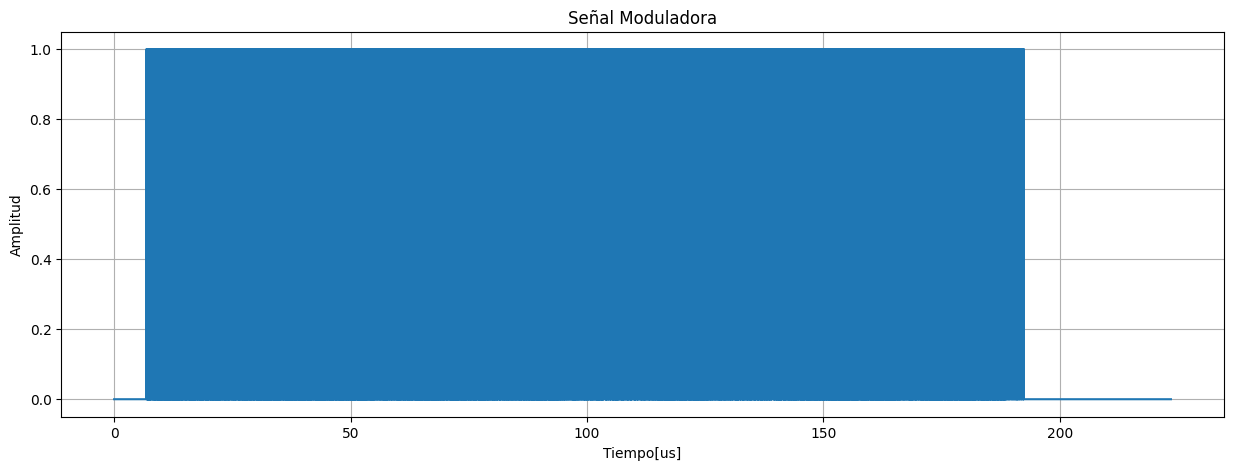

Text(0, 0.5, 'Amplitud')

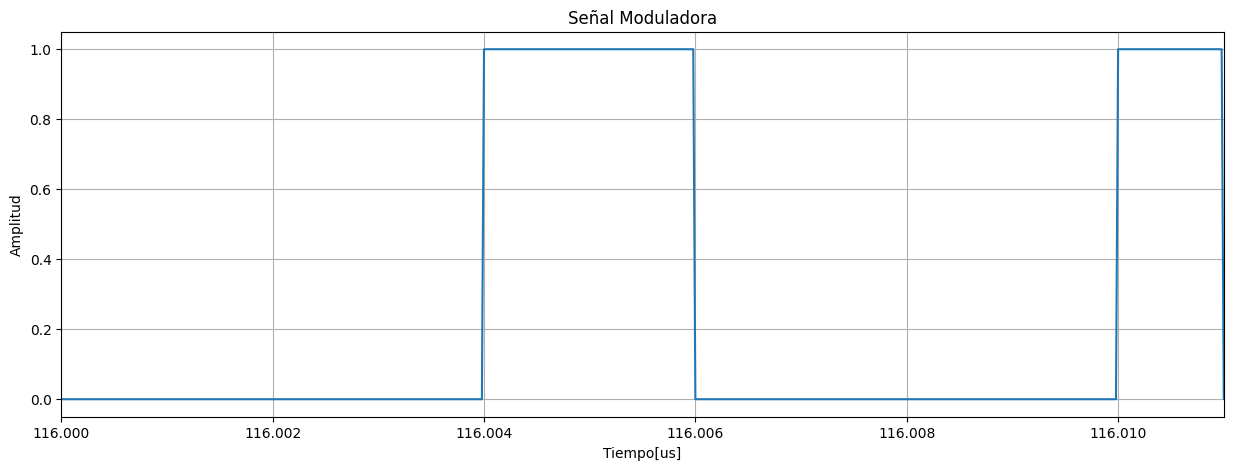

In [16]:
#Graficamos la señal
plt.figure(figsize=(15,5))
plt.plot(t_moduladora,Senial_Moduladora)
plt.grid(True)
#plt.xlim(1+Tb_2*16,1+Tb_2*32)
#plt.xticks(np.arange(1+Tb*16,1+Tb*32,Tb))
plt.title("Señal Moduladora")
plt.xlabel("Tiempo[us]")
plt.ylabel("Amplitud")
plt.show()
#Graficamos con zoom
plt.figure(figsize=(15,5))
plt.plot(t_moduladora,Senial_Moduladora)
plt.grid(True)
plt.xlim(116,116.011)
#plt.xticks(np.arange(1+Tb*16,1+Tb*32,Tb))
plt.title("Señal Moduladora")
plt.xlabel("Tiempo[us]")
plt.ylabel("Amplitud")

# Tasa de bits
Una tasa de bits menor provoca una extension de la señal en el tiempo y una "compresion" del espectro en la frecuencia 

c:\Users\MI PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\MI PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


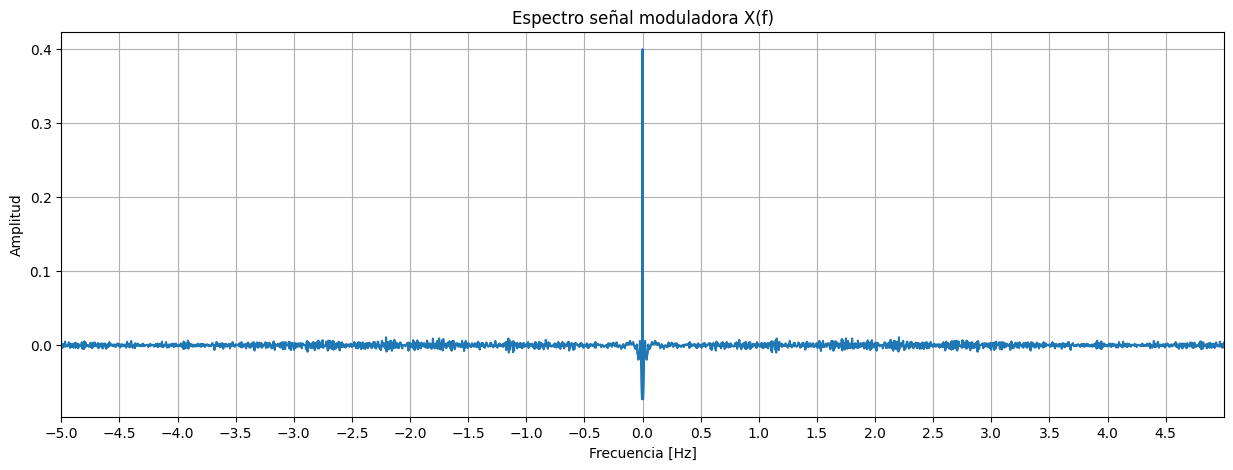

In [17]:
# Obtenemos la FFT de la señal moduladora 
FFT_Moduladora = np.fft.fft(Senial_Moduladora)
# Normalizamos y centramos 
FFT_Moduladora_Shift= np.fft.fftshift(FFT_Moduladora/int(len(Senial_Moduladora)))
# Obtenemos el eje de frecuencias 
f_moduladora = np.fft.fftshift(np.fft.fftfreq(int(len(Senial_Moduladora)),d=1/fs_moduladora))

#Graficamos el espectro 
plt.figure(figsize=(15,5))
plt.plot(f_moduladora,FFT_Moduladora_Shift)
plt.grid(True)
plt.xlabel("Frecuencia [Hz]")
plt.title("Espectro señal moduladora X(f)")
plt.ylabel("Amplitud")
plt.xlim(-5,5)
plt.xticks(np.arange(-5,5,0.5))
plt.show()

Entonces elegimos transmitir a una tasa de bits menor provocando una disminucion en el AB de la señal moduladora

# Señal Portadora
- Como requisito tiene que estar entre 5[kHz] y 10[kHz]

In [ ]:
from math import pi
#Generamos una señal de portadora sinusoidal con una frecuencia de 10kHz y la misma duracion que la señal de audio

Amplitud = 1 #[V]
frecuencia_portadora = 5e3 #[Hz]
duracion_portadora = len(t_moduladora) #[s]
frecuencia_muestreo = 10e4 #Hz
Cantidad_Puntos = frecuencia_muestreo * duracion_portadora #[Hz]

#Eje de tiempo 
#t_portadora = np.linspace(start=0,stop=duracion_portadora,num=int(Cantidad_Puntos),endpoint=False)
#Endpoint=false para que no interprete el comienzo de un nuevo periodo en ese punto 

#Señal sen 
Cos_Portadora = Amplitud * np.cos(2 * frecuencia_portadora * t_moduladora * pi)

print("Cantidad de elementos en el arreglo de la portadora: ",len(Cos_Portadora),",debe ser igual a la cantidad de elementos en la moduladora")

Cantidad de elementos en el arreglo de la portadora:  11174400 debe ser igual a la cantidad de elementos en la moduladora


In [ ]:
#graficamos la señal
plt.figure(figsize=(15,5))
plt.plot(t_moduladora,Cos_Portadora)
plt.title("Señal Portadora")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud [V]")
plt.grid(True)
plt.show()

#graficamos una parte de la señal para visualizar mejor
plt.figure(figsize=(15,5))
plt.plot(t_moduladora,Cos_Portadora)
plt.xlim(0.001,0.002)
plt.xticks(np.arange(0.001,0.002,0.0001))
plt.title("Señal Portadora")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud [V]")
plt.grid(True)
plt.show()

# Modulacion OOK
- Con la señal Portadora y la Moduladora generamos la señal modulada
- En la practica puede lograrse con un modulador balanceado
- en el tiempo se realiza el producto de las señales 

Cantidad de elementos en la señal modulada:  11174400


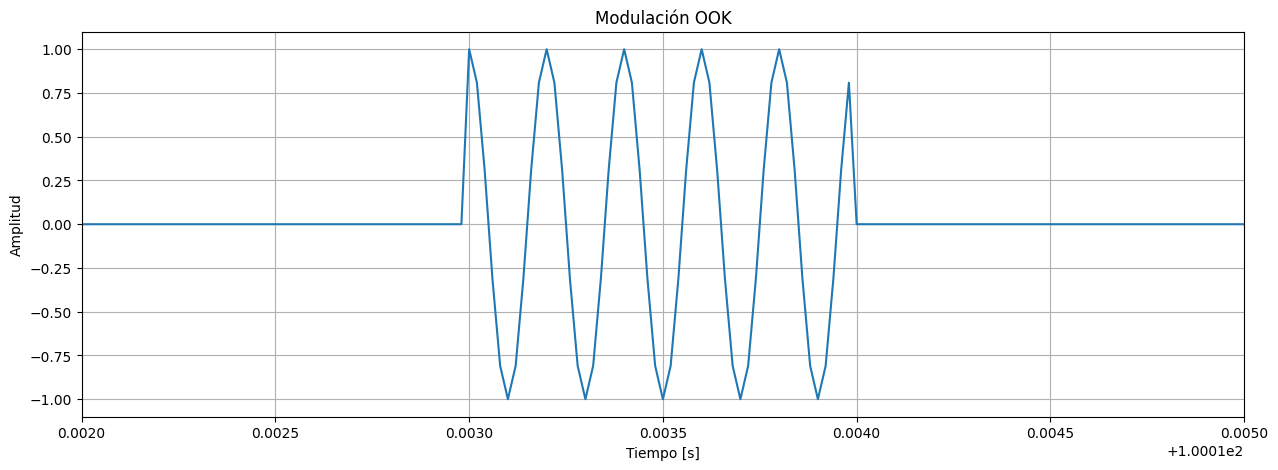

Cada bit dura 1ms y la portadora tiene una frecuencia de 5kHz, entonces un ciclo dura 0.2ms, en un bit entran 5 ciclos de portadora


In [23]:
#Si tenemos un arreglo de bits que representa la señal moduladora y una señal portadora de 10kHz coseniodal 

Senial_OOK = Senial_Moduladora * Cos_Portadora
print("Cantidad de elementos en la señal modulada: ",len(Senial_Moduladora))
#Graficamos la señal 

plt.figure(figsize=(15,5))
plt.plot(t_moduladora, Senial_OOK)  # solo primeros 1000 puntos para visualizar bien
plt.grid(True)
plt.title("Modulación OOK")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.xlim(100.012,100.015)
#plt.xticks(np.arange(0.9,0.9959,0.0001))
plt.show()
print("Cada bit dura 1ms y la portadora tiene una frecuencia de 5kHz, entonces un ciclo dura 0.2ms, en un bit entran 5 ciclos de portadora")

# Conversion de Señal Modulada en archivo de audio .wav
Una vez que tenemos al señal modulada la convertiremos en un archivo de audio 

Cantidad de elementos al normalizar la señal:  11174400


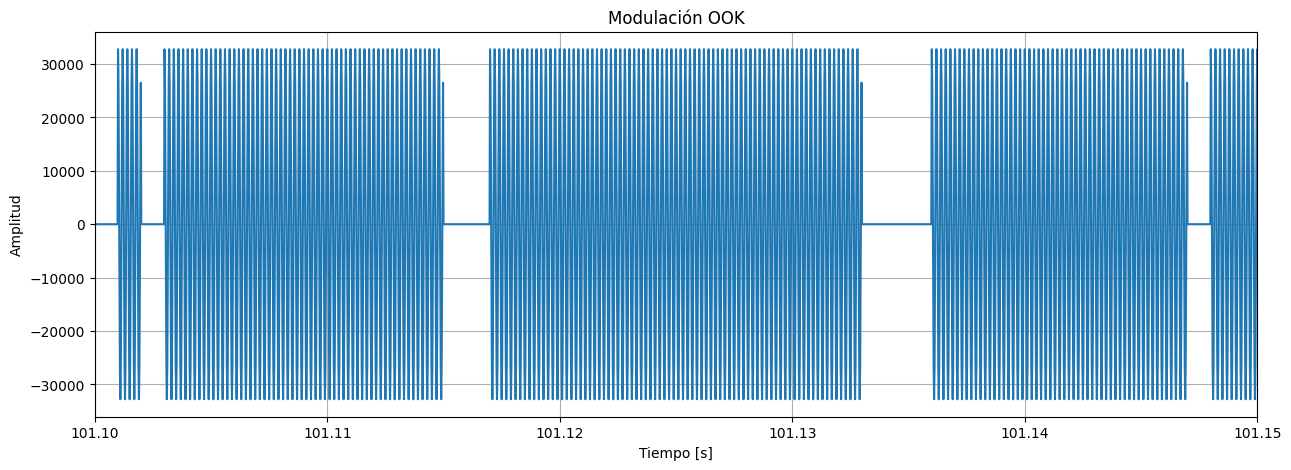

In [27]:
# Convertimos a int16 por ser el tipo de datos que soporta el .wav
Senial_OOK_Normalizada = Senial_OOK * 32767
Senial_OOK_int16 = Senial_OOK_Normalizada.astype(np.int16)
print("Cantidad de elementos al normalizar la señal: ",len(Senial_OOK_int16))
plt.figure(figsize=(15,5))
plt.plot(t_moduladora, Senial_OOK_int16)  # solo primeros 1000 puntos para visualizar bien
plt.grid(True)
plt.title("Modulación OOK")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.xlim(101.1,101.15)
#plt.xticks(np.arange(0.9,0.9959,0.0001))
plt.show()

In [26]:
wavfile.write('Senial_OOK_1000.wav',fs_moduladora,Senial_OOK_int16)